<h3>Predicting the sign of stock returns with daily news

News are important in predicting stock returns. Good news about a company are often followed with positive returns whereas bad news are followed by negative returns. Therefore, correctly incorporating the news information in trading strategies is key for the strategies to be profitable. Numerous papers have been proposed to handle this task:
* "Trading Strategies to Exploit Blog and News Sentiment" (Zhang, Skiena 2010)
* "The Predictive Power of Financial Blogs" (Frisbee 2010)
* "An analysis of verbs in financial news articles and their impact on stock price" (Schumaker 2010)


In this study, the problem of stock return prediction will simplified into a classification task. The goal will be to predict whether the Dow Jones Industrial Average a given day is positive or negative given the headline news the given day. 

Datasets and Inputs

For this study, I will use the data from `Sun, J. (2016, August). Daily News for Stock Market Prediction, Version 1. https://www.kaggle.com/aaron7sun/stocknews.`
I will use the Combined_News_DJIA.csv dataset which contains:
* News data: the top 25 historical news headlines from Reddit WorldNews Channel from 2008-08-08 to 2016-07-01. 
* Dow Jones Industrial Average (DJIA) returns as labels: the label is 1 is the return that day is nonnegative and 0 when the return is negative. 

Evaluation Metrics

For task evaluation, I will use data from 2008-08-08 to 2014-12-31 as Training Set and the Test Set will be the following years data: from 2015-01-02 to 2016-07-01.
The classes in the test set are well balanced, therefore we will not consider the AUROC metric and consider simply the Accuracy metric.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import string

In [2]:
data = pd.read_csv('Combined_News_DJIA.csv')

In [3]:
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [4]:
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

In [5]:
train['Label'].value_counts()

1    873
0    738
Name: Label, dtype: int64

In [6]:
test['Label'].value_counts()

1    192
0    186
Name: Label, dtype: int64

If we predict the most common class (1), we get an accuracy of 192/(192+186) = 50.79%. 

This number is the accuracy of the benchmark model that we want to beat:

$$Accuracy_{benchmark} = 50.79\% $$ 

In [7]:
train.shape

(1611, 27)

In [8]:
test.shape

(378, 27)

In [9]:
trainheadlines = []
for row in range(0,len(train)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))

In [10]:
trainheadlines[0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war" b\'BREAKING: Musharraf to be impeached.\' b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' b\'Did the U.S. Prep Georgia for War with Russia?\'

<h3>Text Processing

a) First, let's remove the sequence `"b" + punctuation` that is characteristic in our dataset

In [11]:
for i in range(0, len(trainheadlines)):
    trainheadlines[i] = re.sub('b[^a-zA-Z ]', '', trainheadlines[i])

In [12]:
trainheadlines[0]

'Georgia \'downs two Russian warplanes\' as countries move to brink of war" BREAKING: Musharraf to be impeached.\' Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" 150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' Did the U.S. Prep Georgia for War with Russia?\' Rice Gives Green Light fo

b) Remove numbers

In [13]:
for i in range(0, len(trainheadlines)):
    trainheadlines[i] = re.sub(r'\d+', '', trainheadlines[i])

In [14]:
trainheadlines[0]

'Georgia \'downs two Russian warplanes\' as countries move to brink of war" BREAKING: Musharraf to be impeached.\' Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing"  Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to  / years, but will be kept longer anyway just because they feel like it." Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' Did the U.S. Prep Georgia for War with Russia?\' Rice Gives Green Light for Isra

c) Remove punctuation

In [17]:
for i in range(0, len(trainheadlines)):
    trainheadlines[i] = trainheadlines[i].translate(str.maketrans("","", string.punctuation))

In [18]:
trainheadlines[0]

'Georgia downs two Russian warplanes as countries move to brink of war BREAKING Musharraf to be impeached Russia Today Columns of troops roll into South Ossetia footage from fighting YouTube Russian tanks are moving towards the capital of South Ossetia which has reportedly been completely destroyed by Georgian artillery fire Afghan children raped with impunity UN official says  this is sick a three year old was raped and they do nothing  Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets Breaking Georgia invades South Ossetia Russia warned it would intervene on SOs side The enemy combatent trials are nothing but a sham Salim Haman has been sentenced to   years but will be kept longer anyway just because they feel like it Georgian troops retreat from S Osettain capital presumably leaving several hundred people killed VIDEO Did the US Prep Georgia for War with Russia Rice Gives Green Light for Israel to Attack Iran Says US has no veto over Israeli milita

d) Stemming

NLTK: "Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language."

This will allow us to reduce the vocabulary length used later in our Bag-of-words model.

In [19]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [20]:
stemmer = PorterStemmer()

In [21]:
def stemSentence(stemmer, sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [22]:
stemSentence(stemmer, trainheadlines[0])

'georgia down two russian warplan as countri move to brink of war break musharraf to be impeach russia today column of troop roll into south ossetia footag from fight youtub russian tank are move toward the capit of south ossetia which ha reportedli been complet destroy by georgian artilleri fire afghan children rape with impun UN offici say thi is sick a three year old wa rape and they do noth russian tank have enter south ossetia whilst georgia shoot down two russian jet break georgia invad south ossetia russia warn it would interven on so side the enemi combat trial are noth but a sham salim haman ha been sentenc to year but will be kept longer anyway just becaus they feel like it georgian troop retreat from S osettain capit presum leav sever hundr peopl kill video did the US prep georgia for war with russia rice give green light for israel to attack iran say US ha no veto over isra militari op announcingclass action lawsuit on behalf of american public against the fbi sorussia and 

In [23]:
for i in range(0, len(trainheadlines)):
    trainheadlines[i] = stemSentence(stemmer, trainheadlines[i])

We can put all the text processing steps in one function that we will use later for cleaning the test dataset:

In [24]:
def text_cleaning(dataset):
    headlines = []
    for row in range(0,len(dataset)):
        headlines.append(' '.join(str(x) for x in dataset.iloc[row,2:27]))
    
    cleaned_headlines = headlines
    for i in range(0, len(headlines)):
        cleaned_headlines[i] = re.sub('b[^a-zA-Z ]', '', headlines[i])
        cleaned_headlines[i] = re.sub(r'\d+', '', cleaned_headlines[i])
        cleaned_headlines[i] = cleaned_headlines[i].translate(str.maketrans("","", string.punctuation))
        cleaned_headlines[i] = stemSentence(stemmer, cleaned_headlines[i])
    return cleaned_headlines

Now let's fit transform the text features into numeric ones with:

* a one-hot-encoding (bag-of-words):
* a bi-gram (n-gram with n=2)
* a tri-gram (n-gram with n=3)
* a four-gram (n-gram with n=4)

In [25]:
onehotvectorizer = CountVectorizer(stop_words='english')
onehottrain = onehotvectorizer.fit_transform(trainheadlines)

bigramvectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2))
bigramtrain = bigramvectorizer.fit_transform(trainheadlines)

trigramvectorizer = CountVectorizer(stop_words='english', ngram_range=(3,3))
trigramtrain = trigramvectorizer.fit_transform(trainheadlines)

fourgramvectorizer = CountVectorizer(stop_words='english', ngram_range=(4,4))
fourgramtrain = fourgramvectorizer.fit_transform(trainheadlines)

<h3>Classifiers

In [27]:
logis_model_onehot = LogisticRegression(solver='liblinear').fit(onehottrain, train["Label"])
logis_model_bigram = LogisticRegression(solver='liblinear').fit(bigramtrain, train["Label"])
logis_model_trigram = LogisticRegression(solver='liblinear').fit(trigramtrain, train["Label"])
logis_model_fourgram = LogisticRegression(solver='liblinear').fit(fourgramtrain, train["Label"])

In [28]:
rf_model_onehot = RandomForestClassifier().fit(onehottrain, train["Label"])
rf_model_bigram = RandomForestClassifier().fit(bigramtrain, train["Label"])
rf_model_trigram = RandomForestClassifier().fit(trigramtrain, train["Label"])
rf_model_fourgram = RandomForestClassifier().fit(fourgramtrain, train["Label"])

<h3>Performance on train and test set</h3>

Note: we have not performed a cross-validation as it is usual in machine learning because of the peculiar nature of our data (dependent on time). Cross-validation is usually performed to fine-tune the parameters of our models.

Here even if a cross-validation were performed, because of the dynamic nature of our data, nothing garanties the performance of the models on newly aggregated data. Hence we here intentionally make the "mistake" of directly looking at the performances on the test data.

In [34]:
test_onehot = onehotvectorizer.transform(text_cleaning(test))
test_bigram = bigramvectorizer.transform(text_cleaning(test))
test_trigram = trigramvectorizer.transform(text_cleaning(test))
test_fourgram = fourgramvectorizer.transform(text_cleaning(test))

Text(0, 0.5, 'Accuracy')

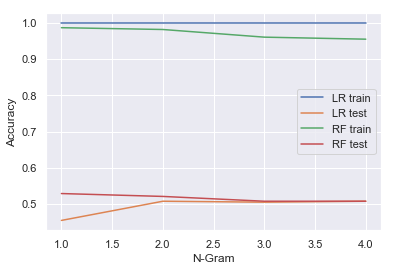

In [35]:
accuracy_train_LR = np.zeros(4)
accuracy_test_LR = np.zeros(4)
accuracy_train_RF = np.zeros(4)
accuracy_test_RF = np.zeros(4)

accuracy_train_LR[0] = logis_model_onehot.score(onehottrain,train["Label"])
accuracy_train_LR[1] = logis_model_bigram.score(bigramtrain,train["Label"])
accuracy_train_LR[2] = logis_model_trigram.score(trigramtrain,train["Label"])
accuracy_train_LR[3] = logis_model_fourgram.score(fourgramtrain,train["Label"])

accuracy_test_LR[0] = logis_model_onehot.score(test_onehot,test["Label"])
accuracy_test_LR[1] = logis_model_bigram.score(test_bigram,test["Label"])
accuracy_test_LR[2] = logis_model_trigram.score(test_trigram,test["Label"])
accuracy_test_LR[3] = logis_model_fourgram.score(test_fourgram,test["Label"])

accuracy_train_RF[0] = rf_model_onehot.score(onehottrain,train["Label"])
accuracy_train_RF[1] = rf_model_bigram.score(bigramtrain,train["Label"])
accuracy_train_RF[2] = rf_model_trigram.score(trigramtrain,train["Label"])
accuracy_train_RF[3] = rf_model_fourgram.score(fourgramtrain,train["Label"])

accuracy_test_RF[0] = rf_model_onehot.score(test_onehot,test["Label"])
accuracy_test_RF[1] = rf_model_bigram.score(test_bigram,test["Label"])
accuracy_test_RF[2] = rf_model_trigram.score(test_trigram,test["Label"])
accuracy_test_RF[3] = rf_model_fourgram.score(test_fourgram,test["Label"])

plt.plot([1,2,3,4], accuracy_train_LR)
plt.plot([1,2,3,4], accuracy_test_LR)

plt.plot([1,2,3,4], accuracy_train_RF)
plt.plot([1,2,3,4], accuracy_test_RF)

plt.legend(['LR train', 'LR test', 'RF train', 'RF test'])
plt.xlabel('N-Gram')
plt.ylabel('Accuracy')

Comments:
* We see very high precision on the train set, this could indicate overfitting on this dataset. In the next step, let's try to soothe this issue with Regularization.
* Going from one-hot-encoding to bi-grams have improved the accuracy of the Logistic Regression model and the performance for the Random Forest stayed nearly constant. However increasing the number to 3 and 4 do not improve the accuracy of the predictions. We will therefore stick to bi-grams. 

Let's inspect the confusion matrix of the bi-gram models:

In [36]:
predictions_lr_bigram = logis_model_bigram.predict(test_bigram)
predictions_rf_bigram = rf_model_bigram.predict(test_bigram)

In [37]:
pd.crosstab(test["Label"], predictions_lr_bigram, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,30,156
1,30,162


In [38]:
pd.crosstab(test["Label"], predictions_rf_bigram, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,20,166
1,15,177


We see that the predictions are severely skewed. Let's try to remediate this problem with Regularization.

Regularization

a) Regularization Logistic Regression 

L2 Regularization:

Text(0, 0.5, 'Accuracy')

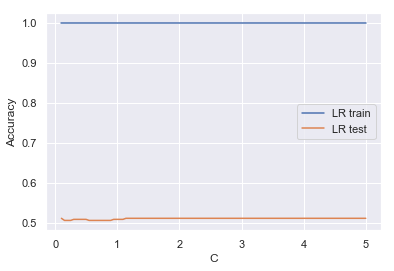

In [39]:
# By default LR uses L2 regression, let's try a stronger regularization strength (we diminish C)
parameters_C = np.linspace(0.1,5, 100)
accuracy_LR_train = np.zeros(len(parameters_C))
accuracy_LR_test = np.zeros(len(parameters_C))

for i,param_C in enumerate(parameters_C):
    logis_model_bigram_reg = LogisticRegression(solver='liblinear', C = param_C).fit(bigramtrain, train["Label"])
    accuracy_LR_train[i] = logis_model_bigram_reg.score(bigramtrain,train["Label"])
    accuracy_LR_test[i] = logis_model_bigram_reg.score(test_bigram,test["Label"])
    
plt.plot(parameters_C, accuracy_LR_train)
plt.plot(parameters_C, accuracy_LR_test)
plt.legend(['LR train', 'LR test'])
plt.xlabel('C')
plt.ylabel('Accuracy')



Regularization unfortunately did not improve our results on the test set. Let's try the same with a L1 Regularization.

L1 Regularization:

Text(0, 0.5, 'Accuracy')

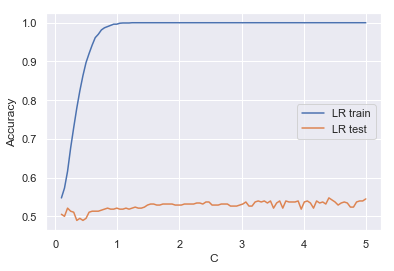

In [40]:
parameters_C = np.linspace(0.1,5, 100)
accuracy_LR_train = np.zeros(len(parameters_C))
accuracy_LR_test = np.zeros(len(parameters_C))

for i,param_C in enumerate(parameters_C):
    logis_model_bigram_reg = LogisticRegression(solver='liblinear', penalty='l1', C = param_C).fit(bigramtrain, train["Label"])
    accuracy_LR_train[i] = logis_model_bigram_reg.score(bigramtrain,train["Label"])
    accuracy_LR_test[i] = logis_model_bigram_reg.score(test_bigram,test["Label"])
    
plt.plot(parameters_C, accuracy_LR_train)
plt.plot(parameters_C, accuracy_LR_test)
plt.legend(['LR train', 'LR test'])
plt.xlabel('C')
plt.ylabel('Accuracy')


In the L1 Regularization, surprisingly, higher values of C increased slightly the performance on the test set. We were expecting that lower values of C (stronger regularization) will lead to better results on the test set.

This is opposite to our intuition, and we will place too much confidence on these high values of C.

Let's consider Regularization for the Random Forest:

b) Regularization Random Forest 

Let's play here with max_depth parameter to try to regularize the model.

Text(0, 0.5, 'Accuracy')

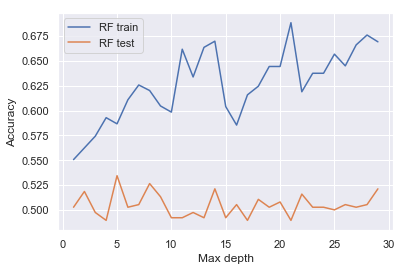

In [41]:
parameters_depths = [i for i in range(1,30)]
accuracy_RF_train = np.zeros(len(parameters_depths))
accuracy_RF_test = np.zeros(len(parameters_depths))

for i,param_depth in enumerate(parameters_depths):
    rf_model_bigram_reg = RandomForestClassifier(max_depth=param_depth).fit(bigramtrain, train["Label"])
    accuracy_RF_train[i] = rf_model_bigram_reg.score(bigramtrain,train["Label"])
    accuracy_RF_test[i] = rf_model_bigram_reg.score(test_bigram,test["Label"])
    
plt.plot(parameters_depths, accuracy_RF_train)
plt.plot(parameters_depths, accuracy_RF_test)
plt.legend(['RF train', 'RF test'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

Here the accuracy values on the test set are quite wiggly. However, one value stands out, the value at depth 5 which gives an accuracy slightly below 55% on the test set. 

More precisely, it has the precision:

In [42]:
accuracy_RF_test[4]

0.5343915343915344

This is above our benchmark model of 50.7% and will be our optimal model for the study. 
Note that this is only around 3% higher than the accuracy of the benchmark model.

<h3>Conclusion


The study was divided in two phases: a first phase on text processing and a second phase on classifiers model building. The first phase goal was to clean the text data (removing punctuations, stopwords, lowercase text, removing numbers, stemming the text) and then to get numerical features with the text with a bag-of-words model associated with n-grams. 
The second phase was to test the Logistic Regression and Random Forest classifiers on test data to see the performance of our model. Moreover, we tried different regularization methods to try to minimize overfitting.
In the end, the model that seems the most promising is the Random Forest Classifier where the maximum_depth is limited to 5, which gives an accuracy of 53.4%. This is only around 3% higher than the Benchmark model that predicts only 1s and the higher performance could simply due by chance. Indeed, countless parameters enter in stock price movements and the top 25 Global News on Reddit are only a tiny fraction of the vast amount of information available to investors. Even though, in this study we simplified the problem to a simple binary prediction, the performance of the different models are not significantly different from the Benchmark model.


Next steps:

* Using Word2Vec instead of N-Grams (for instance by using the library Gensim)
* Considering Convolutional Neural Network / Recurrent Neural Network for prediction
* Use other windows of data for prediction
    * Here we used the popular news on a given day to predict the DJIA index direction on the same day. We could instead use the news over the last $n$ days to predict the direction of stock on day $n+1$.
* Use better quality news and directly connected to financial markets. 
* Combine news data with past stock prices to predict future returns